# Training The Baseline:

Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Install any missing libraries if necessary

In [ ]:
import os
import cv2
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split

Load in the images and their corresponding masks

In [ ]:
import os

def count_files(directory, extension=".tif"):
    # List all files in the directory and count those with the specified extension
    return sum(1 for file in os.listdir(directory) if file.endswith(extension))

# Paths to your image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/images/'
mask_directory = '/gdrive/My Drive/Dataset/patches/masks/'

# Counting the TIFF files in both directories
image_count = count_files(image_directory)
mask_count = count_files(mask_directory)

print(f"Number of image files: {image_count}")
print(f"Number of mask files: {mask_count}")


Number of image files: 5632
Number of mask files: 5632


In [ ]:
import os
import numpy as np
import tifffile as tiff

# Set the image and mask directories
image_directory = '/gdrive/My Drive/Dataset/patches/images'
mask_directory = '/gdrive/My Drive/Dataset/patches/masks'

# Load the images and masks into the lists below
images = []
masks = []

# Sort filenames to ensure matching pairs align
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_directory) if f.endswith(".tif")])

# Determine how many files to load based on percentage (e.g., 20%)
percentage_to_load = 20 / 100.0  # Change 20 to whatever percentage you want
number_of_files_to_load = int(len(image_files) * percentage_to_load)

# Create a mapping of image names to their corresponding mask names by removing '_Buildings'
image_to_mask = {f: f.replace("_patch", "_Buildings_patch") for f in image_files}

# Only iterate over the subset of files determined by the percentage
count = 0
for image_name in image_files[:number_of_files_to_load]:
    img_path = os.path.join(image_directory, image_name)
    mask_name = image_to_mask[image_name]
    mask_path = os.path.join(mask_directory, mask_name)

    if os.path.exists(mask_path):
        img = tiff.imread(img_path)
        mask = tiff.imread(mask_path)

        images.append(img)
        masks.append(mask)
    else:
        print(f'Mask not found for image: {image_name}')

    # update the count
    count += 1
    print(f'Processed: {count}')

# Convert the lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

# Normalize the values
images /= 255.0
masks /= 255.0
masks = masks.reshape((-1, 256, 256, 1))  # Adjust as per your channel needs

Processed: 1
Processed: 2
Processed: 3
Processed: 4
Processed: 5
Processed: 6
Processed: 7
Processed: 8
Processed: 9
Processed: 10
Processed: 11
Processed: 12
Processed: 13
Processed: 14
Processed: 15
Processed: 16
Processed: 17
Processed: 18
Processed: 19
Processed: 20
Processed: 21
Processed: 22
Processed: 23
Processed: 24
Processed: 25
Processed: 26
Processed: 27
Processed: 28
Processed: 29
Processed: 30
Processed: 31
Processed: 32
Processed: 33
Processed: 34
Processed: 35
Processed: 36
Processed: 37
Processed: 38
Processed: 39
Processed: 40
Processed: 41
Processed: 42
Processed: 43
Processed: 44
Processed: 45
Processed: 46
Processed: 47
Processed: 48
Processed: 49
Processed: 50
Processed: 51
Processed: 52
Processed: 53
Processed: 54
Processed: 55
Processed: 56
Processed: 57
Processed: 58
Processed: 59
Processed: 60
Processed: 61
Processed: 62
Processed: 63
Processed: 64
Processed: 65
Processed: 66
Processed: 67
Processed: 68
Processed: 69
Processed: 70
Processed: 71
Processed: 72
P

Perform the Train/Test/Val Split

In [ ]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=1995)

# Further split the training set into training and validation sets (90% train, 10% val)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1995)

# Show the shapes
print('Dataset Shapes:')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val:   {X_val.shape}')
print(f'y_val:   {y_val.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_test:  {y_test.shape}')

# If X_train, X_test, X_val have an extra unnecessary dimension at axis=1, remove it:
X_train = X_train.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)
X_val = X_val.squeeze(axis=1)

Dataset Shapes:
X_train: (810, 1, 256, 256, 3)
y_train: (810, 256, 256, 1)
X_val:   (90, 1, 256, 256, 3)
y_val:   (90, 256, 256, 1)
X_test:  (226, 1, 256, 256, 3)
y_test:  (226, 256, 256, 1)


Define the Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.backend import epsilon
import tensorflow as tf

def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + epsilon())

def jaccard_index(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f + y_pred_f) - intersection
    return (intersection + epsilon()) / (union + epsilon())

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    return true_positives / (predicted_positives + tf.keras.backend.epsilon())

def vgg16_unet(input_size=(256, 256, 3), freeze_vgg16=True):
    inputs = Input(input_size)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    if freeze_vgg16:
        # Freeze the VGG16 layers
        for layer in vgg16.layers:
            layer.trainable = False

    # Skip connections from VGG16 layers
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output
    bridge = vgg16.get_layer("block5_conv3").output

    # Decoder
    up1 = UpSampling2D((2, 2))(bridge)
    up1 = concatenate([up1, s4])
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)

    up2 = UpSampling2D((2, 2))(up1)
    up2 = concatenate([up2, s3])
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)

    up3 = UpSampling2D((2, 2))(up2)
    up3 = concatenate([up3, s2])
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)

    up4 = UpSampling2D((2, 2))(up3)
    up4 = concatenate([up4, s1])
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(up4)

    model = Model(inputs, outputs)
    return model

Compile the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define your model here (for instance, 'model = your_unet_model()')
model = vgg16_unet() # Replace with your actual model

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, jaccard_index, sensitivity, specificity, precision]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 256, 256, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

Train the Model

In [ ]:
# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Model Checkpoint to save the best model during training
model_checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[early_stopping]
)

# Save the Model
model_save_path = '/gdrive/My Drive/Dataset/Models/unet_vgg_1.h5'  # Change 'my_model' to your preferred model name
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Epoch 1/50
26/26 [==============================] - 576s 22s/step - loss: 0.6183 - accuracy: 0.8813 - dice_coefficient: 0.0724 - jaccard_index: 0.0384 - sensitivity: 0.0906 - specificity: 0.9362 - precision: 0.1732 - val_loss: 0.2134 - val_accuracy: 0.9367 - val_dice_coefficient: 0.1395 - val_jaccard_index: 0.0750 - val_sensitivity: 0.0622 - val_specificity: 0.9899 - val_precision: 0.2730
Epoch 2/50
26/26 [==============================] - 575s 22s/step - loss: 0.2150 - accuracy: 0.9332 - dice_coefficient: 0.1635 - jaccard_index: 0.0893 - sensitivity: 0.0778 - specificity: 0.9911 - precision: 0.4105 - val_loss: 0.1864 - val_accuracy: 0.9411 - val_dice_coefficient: 0.1751 - val_jaccard_index: 0.0960 - val_sensitivity: 0.0798 - val_specificity: 0.9935 - val_precision: 0.4262
Epoch 3/50
26/26 [==============================] - 576s 22s/step - loss: 0.1883 - accuracy: 0.9367 - dice_coefficient: 0.2185 - jaccard_index: 0.1229 - sensitivity: 0.1277 - specificity: 0.9914 - precision: 0.4971 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /gdrive/My Drive/Dataset/Models/unet_vgg_1.h5


Evaluate The Model

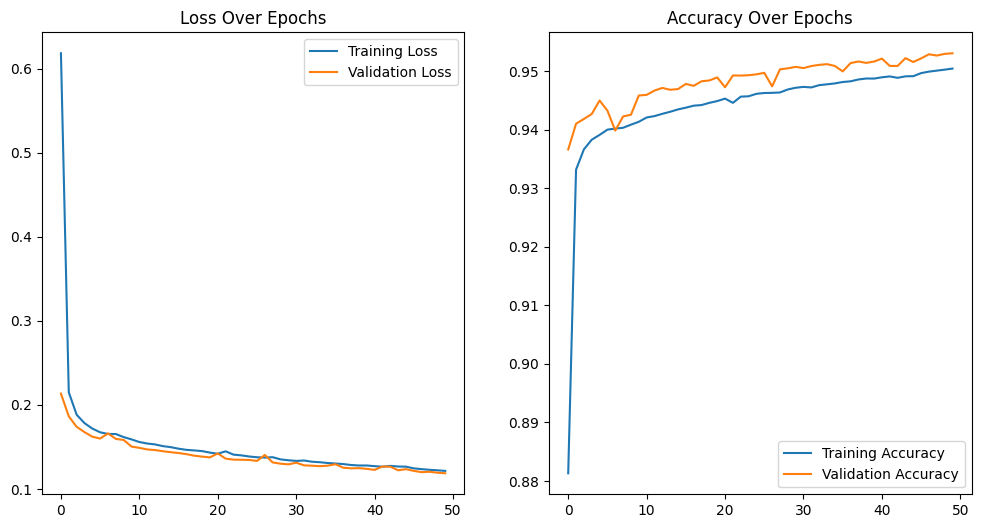

8/8 [==============================] - 68s 8s/step


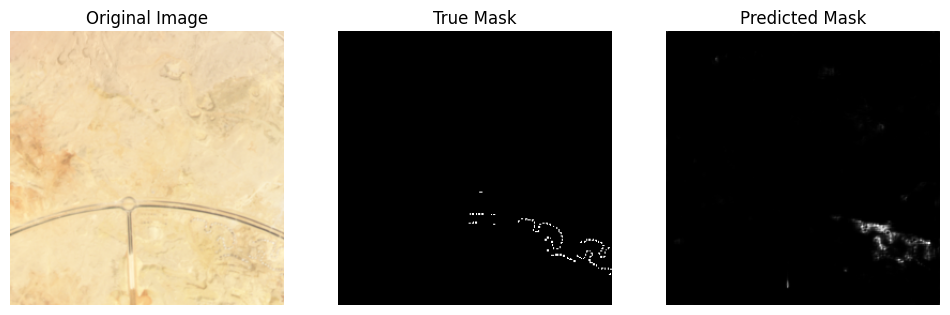

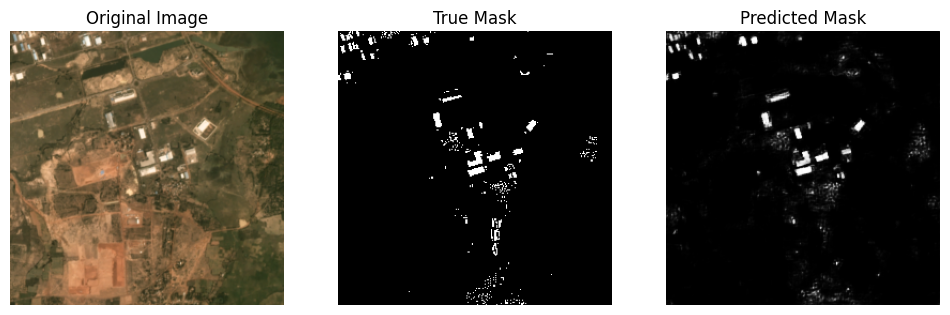

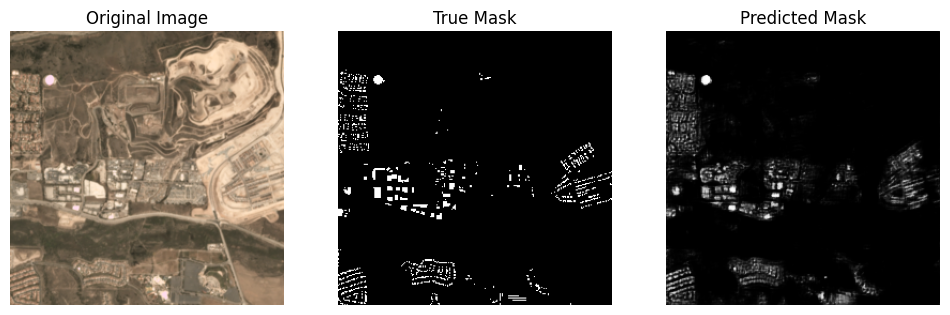

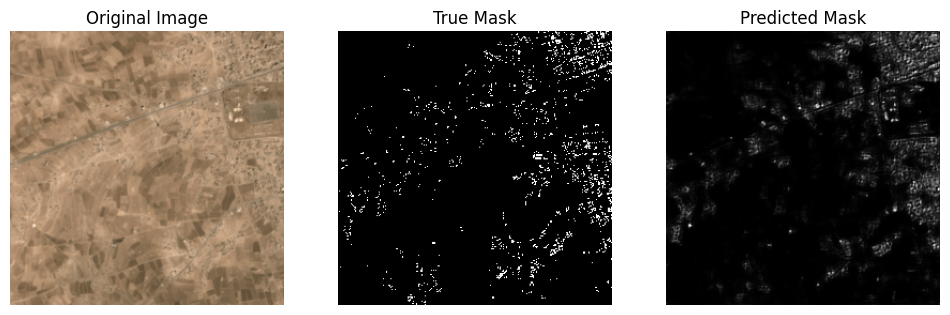

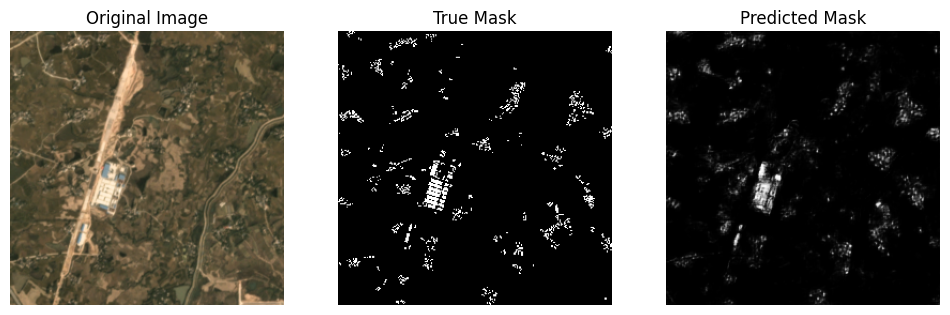

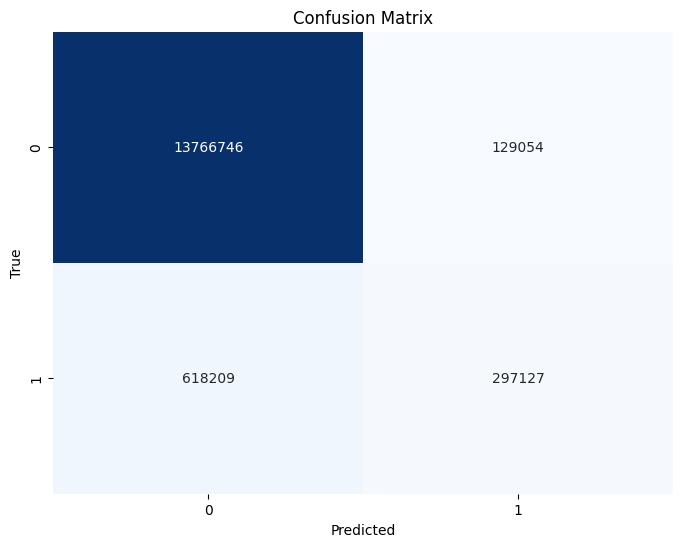

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97  13895800
         1.0       0.70      0.32      0.44    915336

    accuracy                           0.95  14811136
   macro avg       0.83      0.66      0.71  14811136
weighted avg       0.94      0.95      0.94  14811136



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.show()

# Call this function after training
plot_training_history(history)

# Function to show model predictions
def show_predictions(X, y_true, y_pred, num_samples=5):
    indices = np.random.choice(range(len(X)), num_samples, replace=False)

    for i in indices:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()

# Example usage after prediction
y_pred = model.predict(X_test)
show_predictions(X_test, y_test, y_pred)

def plot_confusion_matrix(y_true, y_pred):
    # Flattening the masks
    y_true_f = y_true.flatten()
    y_pred_f = (y_pred.flatten() > 0.5).astype(int)  # Thresholding probabilities to get binary output

    cm = confusion_matrix(y_true_f, y_pred_f)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming y_test and y_pred are available after prediction
plot_confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test.flatten(), (y_pred.flatten() > 0.5).astype(int)))

In [ ]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

def visualize_feature_maps(model, image_index, layer_names):
    # Creates a model that will return the outputs of the specified layers
    layer_outputs = [model.get_layer(name).output for name in layer_names]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)

    # Assuming 'X_train' is your dataset and 'image_index' is the index of the image to inspect
    image = X_train[image_index].reshape(1, 256, 256, 3)  # Reshape image to fit model input
    activations = activation_model.predict(image)  # Returns a list of Numpy arrays: one array per layer activation

    # Plotting the activations of the specified layers
    for layer_activation, layer_name in zip(activations, layer_names):
        num_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # The feature map has shape (1, size, size, num_features).
        n_cols = num_features // 16  # Tiles each activation in a grid
        display_grid = np.zeros((size * n_cols, 16 * size))

        for col in range(n_cols):
            for row in range(16):
                channel_image = layer_activation[0, :, :, col * 16 + row]
                channel_image -= channel_image.mean()  # Post-process to make it visually appealing
                channel_image /= channel_image.std() + 1e-5
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

visualize_feature_maps(model, image_index=5, layer_names=['block1_conv2', 'block2_conv2'])  # Adjust 'image_index' and 'layer_names' as needed

Output hidden; open in https://colab.research.google.com to view.